# **IMPORT LIBRARIES**

In [ ]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
from skimage import io, color
from PIL import Image
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import joblib
import psutil
import tracemalloc

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.models import save_model
from tensorflow.keras.callbacks import Callback

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **DATA LOADING**

In [ ]:
input_dir = "/content/drive/MyDrive/MiniProject/Original"

labels = sorted([d for d in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, d))])
total_images = 0
for label in labels:
  folder_path = os.path.join(input_dir, label)
  images = [f for f in os.listdir(folder_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

  total_images += len(images)

print("Total image samples :", total_images)
print("Unique class labels :", labels)

Total image samples : 600
Unique class labels : ['1', '2', '3', '4']


Label 1:
  Total images : 150
  Sample image : c1_p1_1.jpg
  Image size   : 720 x 1280

Label 2:
  Total images : 150
  Sample image : c2_p1_124.jpg
  Image size   : 720 x 1280

Label 3:
  Total images : 150
  Sample image : c3_p1_105.jpg
  Image size   : 720 x 1280

Label 4:
  Total images : 150
  Sample image : c4_p1_144.jpg
  Image size   : 720 x 1280



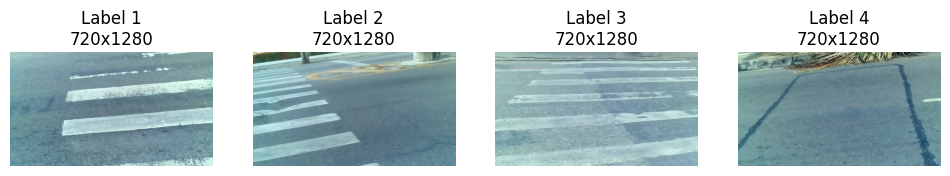

In [ ]:
labels = ["1", "2", "3", "4"]

plt.figure(figsize=(12, 4))

for i, label in enumerate(labels):
    label_path = os.path.join(input_dir, label)

    # Get all image files
    files = [f for f in os.listdir(label_path)
             if f.lower().endswith((".jpg", ".jpeg", ".png"))]

    total_files = len(files)
    sample_file = files[0]

    sample_path = os.path.join(label_path, sample_file)

    img = cv2.imread(sample_path)
    h, w = img.shape[:2]

    # Convert for plotting
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    print(f"Label {label}:")
    print(f"  Total images : {total_files}")
    print(f"  Sample image : {sample_file}")
    print(f"  Image size   : {h} x {w}")
    print()

    # Plot sample
    plt.subplot(1, 4, i+1)
    plt.imshow(img_rgb)
    plt.title(f"Label {label}\n{h}x{w}")
    plt.axis("off")

plt.show()


# **GLOBAL VARIABLES**

In [ ]:
results = {}
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
los = 'sparse_categorical_crossentropy'

# **BENCHMARK COMPARISON**

In [ ]:
train_ds = image_dataset_from_directory(
    "/content/drive/MyDrive/MiniProject/Original",
    validation_split=0.33,
    subset="training",
    shuffle=True,
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    "/content/drive/MyDrive/MiniProject/Original",
    validation_split=0.33,
    subset="validation",
    shuffle=True,
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 600 files belonging to 4 classes.
Using 402 files for training.
Found 600 files belonging to 4 classes.
Using 198 files for validation.


In [ ]:
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['1', '2', '3', '4']


In [ ]:
class StopWhenBothReached(Callback):
  def __init__(self, acc_target=0.95, loss_target=2.0):
    super().__init__()
    self.acc_target = acc_target
    self.loss_target = loss_target

  def on_epoch_end(self, epoch, logs=None):
    val_acc = logs.get("val_accuracy")
    val_loss = logs.get("val_loss")

    # Stop only if BOTH conditions are true
    if val_acc is not None and val_loss is not None:
      if val_acc >= self.acc_target and val_loss <= self.loss_target:
        print(f"\n🔔 Stopping training early: "
              f"val_accuracy={val_acc:.4f} ≥ {self.acc_target}, "
              f"val_loss={val_loss:.4f} ≤ {self.loss_target}")
        self.model.stop_training = True

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [ ]:
model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(224,224,3)),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,372 (42.61 MB)

 Trainable params: 11,169,924 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
model.compile(optimizer=optimizer,loss=los,metrics=['accuracy'])
callback = StopWhenBothReached(acc_target=0.95, loss_target=2.0)

In [ ]:
process = psutil.Process(os.getpid())
mem_before_train = process.memory_info().rss / (1024 ** 2)  # MiB
start_train = time.time()

history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[callback],verbose=1)

train_time = (time.time() - start_train) * 1000  # ms
mem_after_train = process.memory_info().rss / (1024 ** 2)

train_increment_memory = mem_after_train - mem_before_train

acc = history.history["accuracy"][-1] * 100

mem_before_pred = process.memory_info().rss / (1024 ** 2)
start_pred = time.time()

tracemalloc.start()
y_pred_prob = model.predict(val_ds, verbose=0) # Changed X_test to val_ds
_, peak_mem = tracemalloc.get_traced_memory()
tracemalloc.stop()

pred_time = (time.time() - start_pred) * 1000
mem_after_pred = process.memory_info().rss / (1024 ** 2)
pred_increment_memory = mem_after_pred - mem_before_pred

model_path = "tf_model.h5"
save_model(model, model_path)
model_size_kb = os.path.getsize(model_path) / 1024

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 196s 5s/step - accuracy: 0.5497 - loss: 17.2319 - val_accuracy: 0.2273 - val_loss: 399.4638
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.8397 - loss: 3.6152 - val_accuracy: 0.2172 - val_loss: 920.1245
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9441 - loss: 1.8440 - val_accuracy: 0.2172 - val_loss: 509.2963
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.9547 - loss: 1.7160 - val_accuracy: 0.2677 - val_loss: 458.4657
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.9806 - loss: 0.7054 - val_accuracy: 0.2576 - val_loss: 164.7257
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.9827 - loss: 0.4035 - val_accuracy: 0.3636 - val_loss: 91.0185
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.9870 - loss: 0.3545 - val_accuracy: 0.5960 - val_loss: 77.3037
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.9839 - loss: 0.5048 - val_accuracy: 0.72

In [ ]:
results["Tf_Model"] = {
    "Accuracy (%)":acc,
    "Prediction Time (ms)":pred_time,
    "Training Time (ms)": train_time,
    "Training Increment Memory (MiB)": train_increment_memory,
    "Prediction Increment Memory (MiB)": pred_increment_memory,
    "Peak Memory (MiB)": peak_mem,
    "Model Size (KB)": model_size_kb
}
results

{'Tf_Model': {'Accuracy (%)': 98.50746393203735,
  'Prediction Time (ms)': 10237.630605697632,
  'Training Time (ms)': 1766478.6117076874,
  'Training Increment Memory (MiB)': 744.421875,
  'Prediction Increment Memory (MiB)': 0.43359375,
  'Peak Memory (MiB)': 386668,
  'Model Size (KB)': 130973.7890625}}

In [ ]:
# Get the true labels
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Predict probabilities → convert to class labels
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 448ms/step


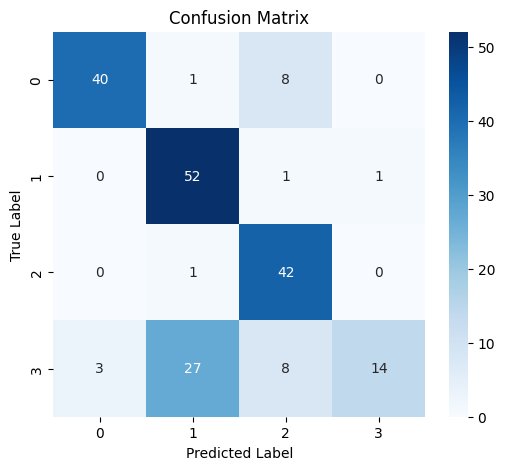

In [ ]:
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# **DATA PREPROCESSING**

**Convert To GrayScale**

In [ ]:
grayscale_dir = "/content/Grayscale"
os.makedirs(grayscale_dir, exist_ok=True)

In [ ]:
for label in os.listdir(input_dir):

  label_path = os.path.join(input_dir, label)

  # Skip non-directories
  if not os.path.isdir(label_path):
    continue

  # Create corresponding folder in output directory
  output_label_path = os.path.join(grayscale_dir, label)
  os.makedirs(output_label_path, exist_ok=True)

  # Process each image inside this label folder
  for file in os.listdir(label_path):
    file_path = os.path.join(label_path, file)

    img = cv2.imread(file_path)

    if img is None:
        print(f"Error reading: {file_path}")
        continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Grayscale

    output_file_path = os.path.join(output_label_path, file)
    cv2.imwrite(output_file_path, gray)
print("Converted to Grayscale")

Converted to Grayscale


Label 1:
  Total images : 150
  Sample image : c1_p1_34.jpg
  Image size   : 720 x 1280

Label 2:
  Total images : 150
  Sample image : c2_p1_13.jpg
  Image size   : 720 x 1280

Label 3:
  Total images : 150
  Sample image : c3_p1_8.jpg
  Image size   : 720 x 1280

Label 4:
  Total images : 150
  Sample image : c4_p1_17.jpg
  Image size   : 720 x 1280



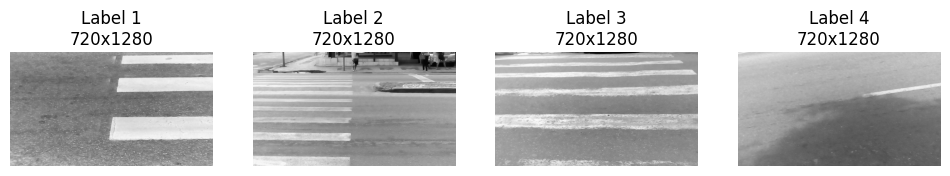

In [ ]:
labels = ["1", "2", "3", "4"]

plt.figure(figsize=(12, 4))

for i, label in enumerate(labels):
  label_path = os.path.join(grayscale_dir, label)

  # Get all image files
  files = [f for f in os.listdir(label_path)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))]

  total_files = len(files)
  sample_file = files[0]

  sample_path = os.path.join(label_path, sample_file)

  img = cv2.imread(sample_path)
  h, w = img.shape[:2]

  # Convert for plotting
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  print(f"Label {label}:")
  print(f"  Total images : {total_files}")
  print(f"  Sample image : {sample_file}")
  print(f"  Image size   : {h} x {w}")
  print()

  # Plot sample
  plt.subplot(1, 4, i+1)
  plt.imshow(img_rgb)
  plt.title(f"Label {label}\n{h}x{w}")
  plt.axis("off")

plt.show()

**Decimate with M=17**

In [ ]:
decimated_dir = "/content/Decimated"
os.makedirs(decimated_dir,exist_ok=True)

In [ ]:
# Decimate Function
def decimate_image(gray_img, M=17):
  return gray_img[::M, ::M]

In [ ]:
for label in os.listdir(grayscale_dir):

  label_path = os.path.join(grayscale_dir, label)
  if not os.path.isdir(label_path):
    continue

  output_label_path = os.path.join(decimated_dir, label)
  os.makedirs(output_label_path, exist_ok=True)

  for file in os.listdir(label_path):
    file_path = os.path.join(label_path, file)

    img = cv2.imread(file_path)
    if img is None:
      print("Could not read:", file_path)
      continue

    decimated = decimate_image(img, M=17)

    # Save file
    output_file_path = os.path.join(output_label_path, file)
    cv2.imwrite(output_file_path, decimated)
print("Decimated (M=17) images saved successfully!")

Decimated (M=17) images saved successfully!


Label 1:
  Total images : 150
  Sample image : c1_p1_34.jpg
  Image size   : 43 x 76

Label 2:
  Total images : 150
  Sample image : c2_p1_13.jpg
  Image size   : 43 x 76

Label 3:
  Total images : 150
  Sample image : c3_p1_8.jpg
  Image size   : 43 x 76

Label 4:
  Total images : 150
  Sample image : c4_p1_17.jpg
  Image size   : 43 x 76



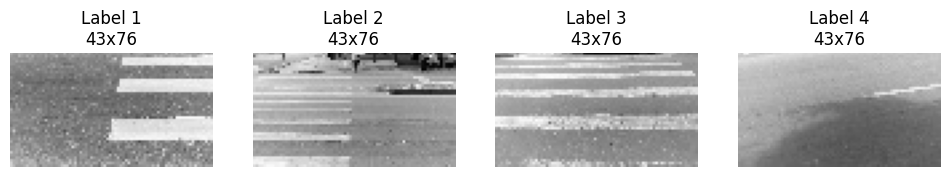

In [ ]:
labels = ["1", "2", "3", "4"]

plt.figure(figsize=(12, 4))

for i, label in enumerate(labels):
  label_path = os.path.join(decimated_dir, label)

  # Get all image files
  files = [f for f in os.listdir(label_path)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))]

  total_files = len(files)
  sample_file = files[0]

  sample_path = os.path.join(label_path, sample_file)

  img = cv2.imread(sample_path)
  h, w = img.shape[:2]

  # Convert for plotting
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  print(f"Label {label}:")
  print(f"  Total images : {total_files}")
  print(f"  Sample image : {sample_file}")
  print(f"  Image size   : {h} x {w}")
  print()

  # Plot sample
  plt.subplot(1, 4, i+1)
  plt.imshow(img_rgb)
  plt.title(f"Label {label}\n{h}x{w}")
  plt.axis("off")

plt.show()

**Thresholding at T=199**

In [ ]:
threshold_dir = "/content/Thresholded"
os.makedirs(decimated_dir,exist_ok=True)

In [ ]:
T = 199  # threshold value

for label in os.listdir(decimated_dir):
  label_path = os.path.join(decimated_dir, label)
  if not os.path.isdir(label_path):
    continue

  out_label_path = os.path.join(threshold_dir, label)
  os.makedirs(out_label_path, exist_ok=True)

  for file in os.listdir(label_path):
    if not file.lower().endswith((".jpg", ".png", ".jpeg")):
      continue

    img_path = os.path.join(label_path, file)
    img = cv2.imread(img_path, 0)

    if img is None:
      print("Error reading:", img_path)
      continue

    # Step 4: Thresholding at T=199
    _, binary_img = cv2.threshold(img, T, 255, cv2.THRESH_BINARY)

    out_path = os.path.join(out_label_path, file)
    cv2.imwrite(out_path, binary_img)

print("Thresholding at T=199 Completed")


Thresholding at T=199 Completed


Label 1:
  Total images : 150
  Sample image : c1_p1_34.jpg
  Image size   : 43 x 76

Label 2:
  Total images : 150
  Sample image : c2_p1_13.jpg
  Image size   : 43 x 76

Label 3:
  Total images : 150
  Sample image : c3_p1_8.jpg
  Image size   : 43 x 76

Label 4:
  Total images : 150
  Sample image : c4_p1_17.jpg
  Image size   : 43 x 76



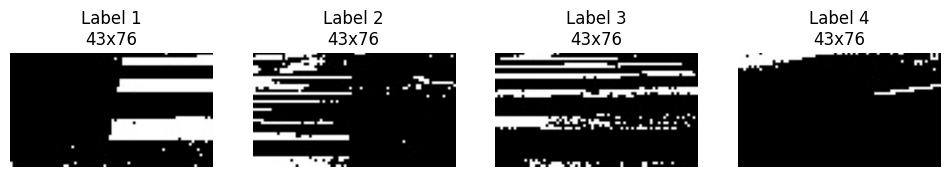

In [ ]:
labels = ["1", "2", "3", "4"]

plt.figure(figsize=(12, 4))

for i, label in enumerate(labels):
  label_path = os.path.join(threshold_dir, label)

  # Get all image files
  files = [f for f in os.listdir(label_path)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))]

  total_files = len(files)
  sample_file = files[0]

  sample_path = os.path.join(label_path, sample_file)

  img = cv2.imread(sample_path)
  h, w = img.shape[:2]

  # Convert for plotting
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  print(f"Label {label}:")
  print(f"  Total images : {total_files}")
  print(f"  Sample image : {sample_file}")
  print(f"  Image size   : {h} x {w}")
  print()

  # Plot sample
  plt.subplot(1, 4, i+1)
  plt.imshow(img_rgb)
  plt.title(f"Label {label}\n{h}x{w}")
  plt.axis("off")

plt.show()

**6-bit Grayscale Quantization**

In [ ]:
quant_dir = "/content/Quantized"
os.makedirs(quant_dir, exist_ok=True)

In [ ]:
# Quantization Function
def quantize_6bit(img):
  return (img // 4).astype(np.uint8)   # 0–63 range

In [ ]:
for label in os.listdir(threshold_dir):
  label_path = os.path.join(threshold_dir, label)
  if not os.path.isdir(label_path):
    continue

  out_label_path = os.path.join(quant_dir, label)
  os.makedirs(out_label_path, exist_ok=True)

  for file in os.listdir(label_path):
    if not file.lower().endswith((".jpg", ".png", ".jpeg")):
      continue

    img_path = os.path.join(label_path, file)
    img = cv2.imread(img_path, 0)

    if img is None:
      print("Error reading:", img_path)
      continue

    quantized = quantize_6bit(img)

    # Save quantized image
    out_path = os.path.join(out_label_path, file)
    cv2.imwrite(out_path, quantized)

print("6-bit Quantization Completed")

6-bit Quantization Completed


Label 1:
  Total images : 150
  Sample image : c1_p1_34.jpg
  Image size   : 43 x 76

Label 2:
  Total images : 150
  Sample image : c2_p1_13.jpg
  Image size   : 43 x 76

Label 3:
  Total images : 150
  Sample image : c3_p1_8.jpg
  Image size   : 43 x 76

Label 4:
  Total images : 150
  Sample image : c4_p1_17.jpg
  Image size   : 43 x 76



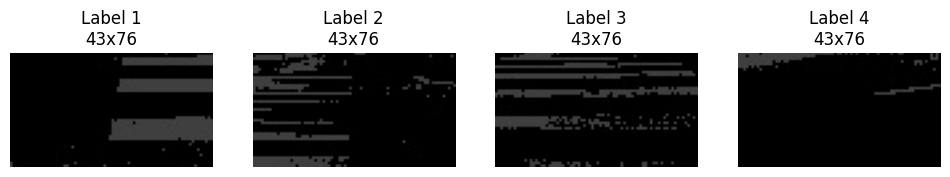

In [ ]:
labels = ["1", "2", "3", "4"]

plt.figure(figsize=(12, 4))

for i, label in enumerate(labels):
  label_path = os.path.join(quant_dir, label)

  # Get all image files
  files = [f for f in os.listdir(label_path)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))]

  total_files = len(files)
  sample_file = files[0]

  sample_path = os.path.join(label_path, sample_file)

  img = cv2.imread(sample_path)
  h, w = img.shape[:2]

  # Convert for plotting
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  print(f"Label {label}:")
  print(f"  Total images : {total_files}")
  print(f"  Sample image : {sample_file}")
  print(f"  Image size   : {h} x {w}")
  print()

  # Plot sample
  plt.subplot(1, 4, i+1)
  plt.imshow(img_rgb)
  plt.title(f"Label {label}\n{h}x{w}")
  plt.axis("off")

plt.show()

# **GLCM FEATURE EXTRACTION**

In [ ]:
class TextureFeatureExtractor:
    def __init__(self, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
        self.distances = distances
        self.angles = angles

    def calculate_glcm(self, image):
        image = image.astype(np.uint8)
        glcm = graycomatrix(
            image,
            distances=self.distances,
            angles=self.angles,
            symmetric=True,
            normed=True
        )
        glcm_avg = np.mean(glcm, axis=(2, 3))
        return glcm_avg

    def asm(self, p):
        return np.sum(np.square(p))

    def contrast(self, p):
        i, j = np.indices(p.shape)
        return np.sum(((i - j) ** 2) * p)

    def correlation(self, p):
        Ng = p.shape[0]
        Px = np.sum(p, axis=1)
        Py = np.sum(p, axis=0)
        Mx = np.sum(np.arange(Ng) * Px)
        My = np.sum(np.arange(Ng) * Py)
        sigma_x = np.sqrt(np.sum((np.arange(Ng) - Mx) ** 2 * Px))
        sigma_y = np.sqrt(np.sum((np.arange(Ng) - My) ** 2 * Py))

        i, j = np.indices(p.shape)
        sum_ij_p = np.sum(i * j * p)

        if sigma_x * sigma_y == 0:
            return 0
        return (sum_ij_p - Mx * My) / (sigma_x * sigma_y)

    def sum_of_squares(self, p):
        i, j = np.indices(p.shape)
        M = np.sum(i * p)
        return np.sum((i - M) ** 2 * p)

    def idm(self, p):
        i, j = np.indices(p.shape)
        return np.sum((1 / (1 + (i - j) ** 2)) * p)

    def sum_average(self, p):
        Ng = p.shape[0]
        P = np.zeros(2 * Ng)
        for i in range(Ng):
            for j in range(Ng):
                P[i + j] += p[i, j]
        return np.sum(np.arange(2, 2 * Ng) * P[2:])

    def sum_entropy(self, p):
        Ng = p.shape[0]
        P = np.zeros(2 * Ng)
        for i in range(Ng):
            for j in range(Ng):
                P[i + j] += p[i, j]

        return -np.sum([P[k] * np.log(P[k]) for k in range(2, 2 * Ng) if P[k] > 0])

    def sum_variance(self, p):
        f8 = self.sum_entropy(p)
        Ng = p.shape[0]
        P = np.zeros(2 * Ng)
        for i in range(Ng):
            for j in range(Ng):
                P[i + j] += p[i, j]

        return np.sum([(k - f8) ** 2 * P[k] for k in range(2, 2 * Ng)])

    def entropy(self, p):
        p_nz = p[p > 0]
        return -np.sum(p_nz * np.log(p_nz))

    def difference_variance(self, p):
        Ng = p.shape[0]
        P = np.zeros(Ng)
        for i in range(Ng):
            for j in range(Ng):
                P[abs(i - j)] += p[i, j]

        mean_diff = np.sum(np.arange(Ng) * P)
        return np.sum(((np.arange(Ng) - mean_diff) ** 2) * P)

    def difference_entropy(self, p):
        Ng = p.shape[0]
        P = np.zeros(Ng)
        for i in range(Ng):
            for j in range(Ng):
                P[abs(i - j)] += p[i, j]

        return -np.sum([P[i] * np.log(P[i]) for i in range(Ng) if P[i] > 0])

    def information_correlation1(self, p):
        Ng = p.shape[0]
        Px = np.sum(p, axis=1)
        Py = np.sum(p, axis=0)

        HX = -np.sum(Px[Px > 0] * np.log(Px[Px > 0]))
        HY = -np.sum(Py[Py > 0] * np.log(Py[Py > 0]))
        HXY = self.entropy(p)

        HXY1 = 0.0
        for i in range(Ng):
            for j in range(Ng):
                if p[i, j] > 0 and Px[i] > 0 and Py[j] > 0:
                    HXY1 += p[i, j] * np.log(Px[i] * Py[j])
        HXY1 = -HXY1

        if max(HX, HY) == 0:
            return 0
        return (HXY - HXY1) / max(HX, HY)

    def information_correlation2(self, p):
        Ng = p.shape[0]
        Px = np.sum(p, axis=1)
        Py = np.sum(p, axis=0)
        HXY = self.entropy(p)

        HXY2 = 0.0
        for i in range(Ng):
            for j in range(Ng):
                prod = Px[i] * Py[j]
                if prod > 0:
                    HXY2 += prod * np.log(prod)
        HXY2 = -HXY2

        if HXY2 - HXY <= 0:
            return 0
        return np.sqrt(1 - np.exp(-2.0 * (HXY2 - HXY)))

    def maximal_correlation(self, p):
        Ng = p.shape[0]
        Px = np.sum(p, axis=1) + 1e-10
        Py = np.sum(p, axis=0) + 1e-10

        Q = np.zeros((Ng, Ng))
        for i in range(Ng):
            for j in range(Ng):
                for k in range(Ng):
                    Q[i, j] += (p[i, k] * p[j, k]) / (Px[i] * Py[k])

        eigenvalues = np.linalg.eigvals(Q)
        eigenvalues = np.sort(eigenvalues)[::-1]

        if len(eigenvalues) >= 2:
            return np.sqrt(np.real(eigenvalues[1]))
        return 0.0

    def homogeneity(self, p):
        return self.idm(p)

    def autocorrelation(self, p):
        i, j = np.indices(p.shape)
        return np.sum(i * j * p)

    def dissimilarity(self, p):
        i, j = np.indices(p.shape)
        return np.sum(np.abs(i - j) * p)

    def cluster_shade(self, p):
        Ng = p.shape[0]
        Px = np.sum(p, axis=1)
        Py = np.sum(p, axis=0)
        Mx = np.sum(np.arange(Ng) * Px)
        My = np.sum(np.arange(Ng) * Py)

        i, j = np.indices(p.shape)
        return np.sum(((i + j - Mx - My) ** 3) * p)

    def cluster_prominence(self, p):
        Ng = p.shape[0]
        Px = np.sum(p, axis=1)
        Py = np.sum(p, axis=0)
        Mx = np.sum(np.arange(Ng) * Px)
        My = np.sum(np.arange(Ng) * Py)

        i, j = np.indices(p.shape)
        return np.sum(((i + j - Mx - My) ** 4) * p)

    def maximum_probability(self, p):
        return np.max(p)

    def sum_mean(self, p):
        return self.sum_average(p)

    def cluster_tendency(self, p):
        return self.cluster_shade(p)

    def difference_mean(self, p):
        Ng = p.shape[0]
        P = np.zeros(Ng)
        for i in range(Ng):
            for j in range(Ng):
                P[abs(i - j)] += p[i, j]
        return np.sum(np.arange(Ng) * P)

    def inertia(self, p):
        return self.contrast(p)

    def extract_all_features(self, image):
        glcm = self.calculate_glcm(image)
        return [
            self.asm(glcm),
            self.contrast(glcm),
            self.correlation(glcm),
            self.sum_of_squares(glcm),
            self.idm(glcm),
            self.sum_average(glcm),
            self.sum_entropy(glcm),
            self.sum_variance(glcm),
            self.entropy(glcm),
            self.difference_variance(glcm),
            self.difference_entropy(glcm),
            self.information_correlation1(glcm),
            self.information_correlation2(glcm),
            self.maximal_correlation(glcm),
            self.homogeneity(glcm),
            self.autocorrelation(glcm),
            self.dissimilarity(glcm),
            self.cluster_shade(glcm),
            self.cluster_prominence(glcm),
            self.maximum_probability(glcm),
            self.sum_mean(glcm),
            self.cluster_tendency(glcm),
            self.difference_mean(glcm),
            self.inertia(glcm),
        ]

In [ ]:
def process_dataset(root_folder, output_csv='texture_features.csv'):
    feature_names = [
        'ASM', 'Contrast', 'Correlation', 'Sum_of_Squares', 'IDM',
        'Sum_Average', 'Sum_Entropy', 'Sum_Variance', 'Entropy',
        'Difference_Variance', 'Difference_Entropy', 'Info_Correlation1',
        'Info_Correlation2', 'Maximal_Correlation', 'Homogeneity',
        'Autocorrelation', 'Dissimilarity', 'Cluster_Shade',
        'Cluster_Prominence', 'Maximum_Probability', 'Sum_Mean',
        'Cluster_Tendency', 'Difference_Mean', 'Inertia', 'Label'
    ]

    extractor = TextureFeatureExtractor()
    all_features = []

    class_folders = [f for f in os.listdir(root_folder)
                     if os.path.isdir(os.path.join(root_folder, f))]

    print(f"Found {len(class_folders)} classes: {class_folders}")

    i = 0
    stop_processing = False

    for class_folder in class_folders:
        if stop_processing:
            break  # break outer loop

        class_path = os.path.join(root_folder, class_folder)
        image_files = [f for f in os.listdir(class_path)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp'))]

        print(f"Processing {len(image_files)} images in class {class_folder}")

        for image_file in image_files:
            if i > 4:
                stop_processing = True
                break  # break inner loop

            try:
                image_path = os.path.join(class_path, image_file)
                image = np.array(Image.open(image_path).convert('L'))

                features = extractor.extract_all_features(image)
                features.append(class_folder)
                all_features.append(features)

                print(f"Processed: {image_file} - Class: {class_folder}")
                i += 1
                print(i)

            except Exception as e:
                print(f"Error processing {image_file}: {e}")

    # Save dataframe
    df = pd.DataFrame(all_features, columns=feature_names)
    df.to_csv(output_csv, index=False)

    print("\nFeature extraction complete!")
    print(f"Total images processed: {len(all_features)}")
    print(f"Saved CSV to: {output_csv}")

    return df


In [ ]:
dataset_root = "/content/Quantized"
features_df = process_dataset(dataset_root, 'GLCM_feature_dataset.csv')

print("\nDataset Summary:")
print(f"Total samples: {len(features_df)}")
print(f"Features per sample: {len(features_df.columns)-1}")
print(f"Classes: {features_df['Label'].unique()}")
print(features_df['Label'].value_counts())

Found 4 classes: ['3', '2', '4', '1']
Processing 150 images in class 3
Processed: c3_p1_8.jpg - Class: 3
1
Processed: c3_p1_81.jpg - Class: 3
2
Processed: c3_p1_142.jpg - Class: 3
3
Processed: c3_p1_70.jpg - Class: 3
4
Processed: c3_p1_57.jpg - Class: 3
5

Feature extraction complete!
Total images processed: 5
Saved CSV to: GLCM_feature_dataset.csv

Dataset Summary:
Total samples: 5
Features per sample: 24
Classes: ['3']
Label
3    5
Name: count, dtype: int64


In [ ]:
img_path = "/content/drive/MyDrive/MiniProject/Original/1/c1_p1_118.jpg"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = img.astype(np.uint8)

glcm = graycomatrix(img,
                    distances=[1],
                    angles=[0],
                    levels=256,
                    symmetric=True,
                    normed=False)

print("GLCM Matrix Shape:", glcm.shape)
print("GLCM Matrix (distance=1, angle=0):")
print(glcm[:, :, 0, 0])

GLCM Matrix Shape: (256, 256, 1, 1)
GLCM Matrix (distance=1, angle=0):
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  3 10]
 [ 0  0  0 ...  3  6 17]
 [ 0  0  0 ... 10 17 44]]


# **BASELINE METHOD (24 Features)**

In [ ]:
features_24 = pd.read_csv("/content/drive/MyDrive/MiniProject/texture_features_dataset.csv")
features_24.head()

,ASM,Contrast,Correlation,Sum_of_Squares,IDM,Sum_Average,Sum_Entropy,Sum_Variance,Entropy,Difference_Variance,...,Autocorrelation,Dissimilarity,Cluster_Shade,Cluster_Prominence,Maximum_Probability,Sum_Mean,Cluster_Tendency,Difference_Mean,Inertia,Label
0,0.001332,52.605790,0.956374,602.922401,0.369020,362.242660,5.145706,129877.318506,7.295964,39.612539,...,33381.555739,3.604615,95794.277544,1.720826e+07,0.005068,362.242660,95794.277544,3.604615,52.605790,3
1,0.000688,115.170141,0.951796,1194.611409,0.258250,366.878217,5.386352,135339.644530,8.009618,82.580624,...,34786.932930,5.708723,-383878.920769,1.451676e+08,0.003449,366.878217,-383878.920769,5.708723,115.170141,3
2,0.000832,42.418592,0.982685,1224.938527,0.347761,296.319847,5.512528,89426.232705,7.637142,30.722985,...,23155.092205,3.419884,83106.580412,4.574737e+07,0.002731,296.319847,83106.580412,3.419884,42.418592,3
3,0.000900,63.231844,0.928819,444.164305,0.284934,346.207789,5.095589,118070.958329,7.571578,41.625760,...,30377.506688,4.648235,22123.492049,7.105734e+06,0.003236,346.207789,22123.492049,4.648235,63.231844,3
4,0.001364,195.434899,0.944388,1757.119833,0.297091,342.118462,5.237448,120321.862109,7.777154,154.094246,...,30920.662930,6.429670,190119.395853,1.777098e+08,0.015727,342.118462,190119.395853,6.429670,195.434899,3


In [ ]:
X_Model24 = features_24.drop("Label", axis=1)
y_Model24 = features_24["Label"]

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])
param_grid = {
    'svm__kernel': ['linear', 'rbf'],
    'svm__C': [0.1, 1, 10, 20, 50, 100],
    'svm__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring="accuracy"
)

grid.fit(X_Model24, y_Model24)

print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

Best Parameters: {'svm__C': 50, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Best CV Accuracy: 0.7083333333333334


In [ ]:
X_train_Model24, X_test_Model24, y_train_Model24, y_test_Model24 = train_test_split(X_Model24, y_Model24, test_size=0.2, stratify=y_Model24, random_state=42)
best_model_Model24 = grid.best_estimator_

In [ ]:
process_Model24 = psutil.Process(os.getpid())

mem_before_train_Model24 = process_Model24.memory_info().rss / (1024 ** 2)  # MiB
start_train_Model24 = time.time()
best_model_Model24.fit(X_train_Model24, y_train_Model24)

train_time_Model24 = (time.time() - start_train_Model24) * 1000  # ms
mem_after_train_Model24 = process_Model24.memory_info().rss / (1024 ** 2)

training_increment_mem_Model24 = mem_after_train_Model24 - mem_before_train_Model24

mem_before_pred_Model24 = process_Model24.memory_info().rss / (1024 ** 2)
start_pred_Model24 = time.time()

tracemalloc.start()
y_pred_Model24 = best_model_Model24.predict(X_test_Model24)
_, peak_memory_Model24 = tracemalloc.get_traced_memory()
tracemalloc.stop()

pred_time_Model24 = (time.time() - start_pred_Model24) * 1000  # ms
mem_after_pred_Model24 = process_Model24.memory_info().rss / (1024 ** 2)

prediction_increment_mem_Model24 = mem_after_pred_Model24 - mem_before_pred_Model24
peak_memory_mib_Model24 = peak_memory_Model24 / (1024 ** 2)  # convert to MiB

acc_Model24 = float(grid.best_score_ * 100)

model_path_Model24 = "Model24.pkl"
joblib.dump(best_model_Model24, model_path_Model24)

model_size_kb_Model24 = os.path.getsize(model_path_Model24) / 1024

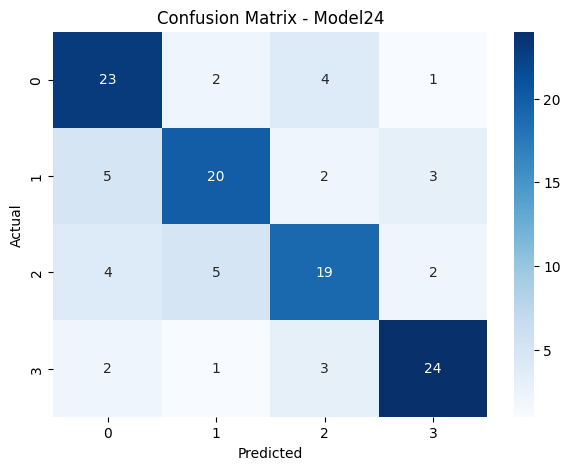

In [ ]:
cm_Model24 = confusion_matrix(y_test_Model24, y_pred_Model24)

plt.figure(figsize=(7,5))
sns.heatmap(cm_Model24, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Model24')
plt.show()


In [ ]:
results["Model24"] = {
    "Accuracy (%)": acc_Model24,
    "Prediction Time (ms)": pred_time_Model24,
    "Training Time (ms)": train_time_Model24,
    "Training Increment Memory (MiB)": training_increment_mem_Model24,
    "Prediction Increment Memory (MiB)": prediction_increment_mem_Model24,
    "Peak Memory (MiB)": peak_memory_mib_Model24,
    "Model Size (KB)": model_size_kb_Model24
}

# **COMPLEXITY BASED METHOD (10 Features)**

In [ ]:
data_dir = "/content/drive/MyDrive/MiniProject/10_FEATURES_M17_CM6b_TH199.csv"
df_10 = pd.read_csv(data_dir)
df_10.head()

,ASM,Contrast,IDM,Entropy,Homogeneity,Sum Mean,Maximum Probability,Dissimilarity,Difference mean,Autocorrelation,Class
0,0.718484,167.824806,0.885132,0.488888,0.892471,6.818140,0.847442,3.271628,-0.077364,291.956279,1
1,0.503199,193.217674,0.815848,0.849199,0.828933,14.135969,0.708527,3.989147,-0.077054,682.605271,1
2,0.857481,101.301705,0.945159,0.232984,0.947614,2.914419,0.925891,1.983256,-0.041550,102.298605,1
3,0.840310,82.300465,0.940856,0.272157,0.944588,3.662481,0.916589,1.664186,-0.049767,156.233798,1
4,0.718484,167.824806,0.885132,0.488888,0.892471,6.818140,0.847442,3.271628,-0.077364,291.956279,1


In [ ]:
X_Model10 = df_10.drop("Class", axis=1)
y_Model10 = df_10["Class"]

X_train_Model10, X_test_Model10, y_train_Model10, y_test_Model10 = train_test_split(
    X_Model10, y_Model10, test_size=0.2, random_state=42, stratify=y_Model10
)

scaler_Model10 = StandardScaler()
X_train_scaled_Model10 = scaler_Model10.fit_transform(X_train_Model10)
X_test_scaled_Model10 = scaler_Model10.transform(X_test_Model10)

svm_Model10 = SVC(kernel="rbf", C=10, gamma="scale")

In [ ]:
process_Model10 = psutil.Process(os.getpid())

mem_before_train_Model10 = process_Model10.memory_info().rss / (1024 ** 2)  # MiB
start_train_Model10 = time.time()

svm_Model10.fit(X_train_scaled_Model10, y_train_Model10)

train_time_Model10 = (time.time() - start_train_Model10) * 1000  # ms
mem_after_train_Model10 = process_Model10.memory_info().rss / (1024 ** 2)

training_increment_mem_Model10 = mem_after_train_Model10 - mem_before_train_Model10

mem_before_pred_Model10 = process_Model10.memory_info().rss / (1024 ** 2)
start_pred_Model10 = time.time()

tracemalloc.start()
y_pred_Model10 = svm_Model10.predict(X_test_scaled_Model10)
_, peak_memory_Model10 = tracemalloc.get_traced_memory()
tracemalloc.stop()

pred_time_Model10 = (time.time() - start_pred_Model10) * 1000  # ms
mem_after_pred_Model10 = process_Model10.memory_info().rss / (1024 ** 2)

prediction_increment_mem_Model10 = mem_after_pred_Model10 - mem_before_pred_Model10
peak_memory_mib_Model10 = peak_memory_Model10 / (1024 ** 2)

acc_Model10 = accuracy_score(y_test_Model10, y_pred_Model10) * 100

model_path_Model10 = "Model10.pkl"
joblib.dump(svm_Model10, model_path_Model10)

model_size_kb_Model10 = os.path.getsize(model_path_Model10) / 1024

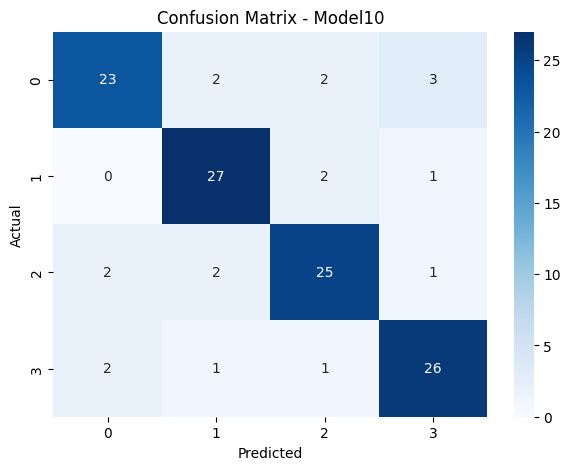

In [ ]:
cm_Model10 = confusion_matrix(y_test_Model10, y_pred_Model10)

plt.figure(figsize=(7,5))
sns.heatmap(cm_Model10, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Model10")
plt.show()

In [ ]:
results["Model10"] = {
    "Accuracy (%)": acc_Model10,
    "Prediction Time (ms)": pred_time_Model10,
    "Training Time (ms)": train_time_Model10,
    "Training Increment Memory (MiB)": training_increment_mem_Model10,
    "Prediction Increment Memory (MiB)": prediction_increment_mem_Model10,
    "Peak Memory (MiB)": peak_memory_mib_Model10,
    "Model Size (KB)": model_size_kb_Model10
}

# **COMPLEXITY AND CORRELATION BASED METHOD (5 Features)**

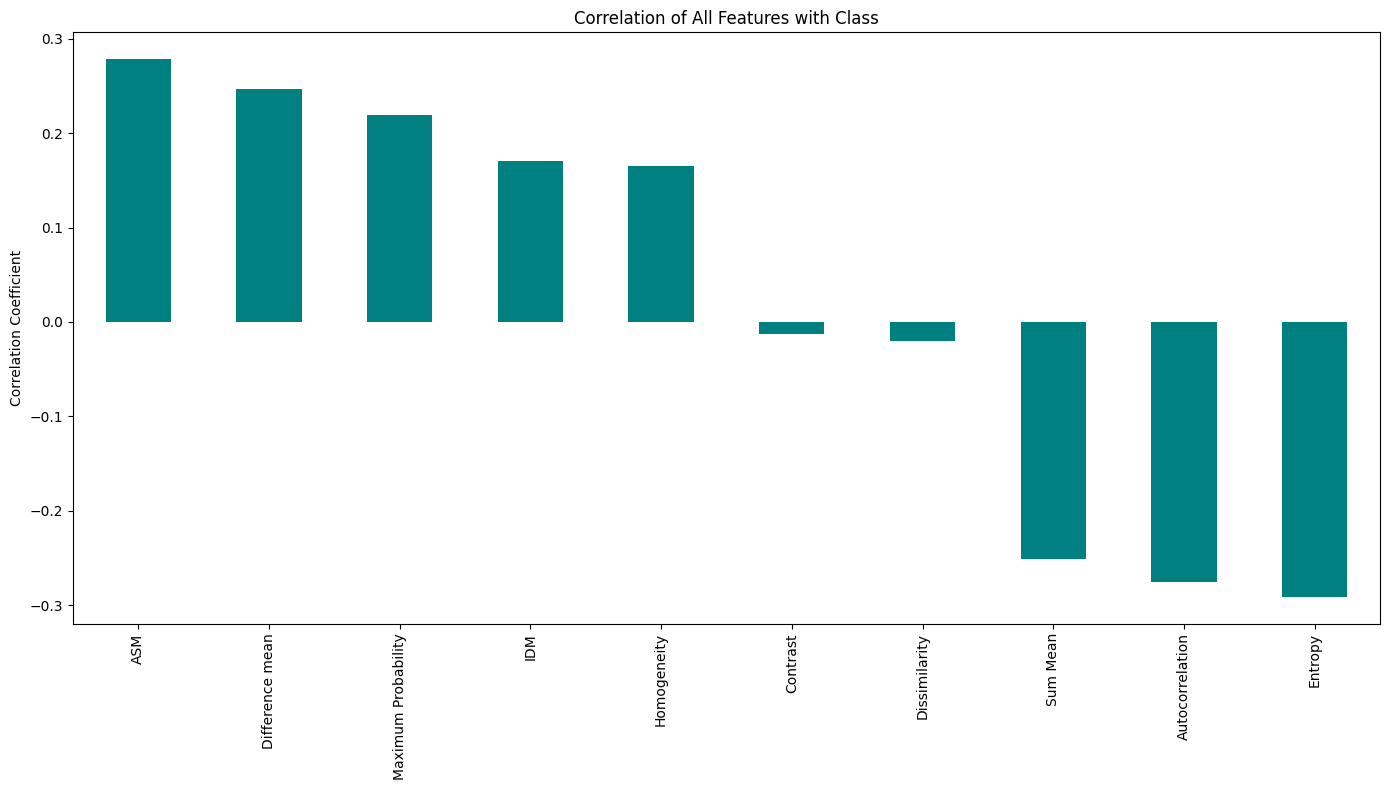

In [ ]:
cor_target = df_10.corr()['Class'].sort_values(ascending=False)
cor_target = cor_target.drop('Class') # Dropped Target

# Plot the correlation
plt.figure(figsize=(14, 8))
cor_target.plot(kind='bar', color='teal')

# Plot settings
plt.title('Correlation of All Features with Class')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
def select_features_by_correlation(df, target, corr_threshold=0.1):
    corr_matrix = df.corr(method='pearson')
    corr_with_target = corr_matrix[target].abs()

    selected = corr_with_target[corr_with_target > corr_threshold].index.tolist()

    if target in selected:
        selected.remove(target)

    return selected

selected_features = select_features_by_correlation(df_10, target="Class", corr_threshold=0.15)
print("Selected Features:", selected_features)

Selected Features: ['ASM', 'IDM', 'Entropy', 'Homogeneity', 'Sum Mean', 'Maximum Probability', 'Difference mean', 'Autocorrelation']


In [ ]:
features_list_5 = ['ASM','Contrast','IDM','Sum Mean','Difference mean','Class']
df_5 = df_10[features_list_5]
df_5.head()

,ASM,Contrast,IDM,Sum Mean,Difference mean,Class
0,0.718484,167.824806,0.885132,6.818140,-0.077364,1
1,0.503199,193.217674,0.815848,14.135969,-0.077054,1
2,0.857481,101.301705,0.945159,2.914419,-0.041550,1
3,0.840310,82.300465,0.940856,3.662481,-0.049767,1
4,0.718484,167.824806,0.885132,6.818140,-0.077364,1


In [ ]:
X_Model5 = df_5.drop("Class", axis=1)
y_Model5 = df_5["Class"]

X_train_Model5, X_test_Model5, y_train_Model5, y_test_Model5 = train_test_split(
    X_Model5, y_Model5, test_size=0.2, random_state=42, stratify=y_Model5
)

scaler_Model5 = StandardScaler()
X_train_scaled_Model5 = scaler_Model5.fit_transform(X_train_Model5)
X_test_scaled_Model5 = scaler_Model5.transform(X_test_Model5)

svm_Model5 = SVC(kernel="rbf", C=10, gamma="scale")

In [ ]:
process_Model5 = psutil.Process(os.getpid())

mem_before_train_Model5 = process_Model5.memory_info().rss / (1024 ** 2)  # MiB
start_train_Model5 = time.time()

svm_Model5.fit(X_train_scaled_Model5, y_train_Model5)

train_time_Model5 = (time.time() - start_train_Model5) * 1000  # ms
mem_after_train_Model5 = process_Model5.memory_info().rss / (1024 ** 2)

training_increment_mem_Model5 = mem_after_train_Model5 - mem_before_train_Model5

mem_before_pred_Model5 = process_Model5.memory_info().rss / (1024 ** 2)
start_pred_Model5 = time.time()

tracemalloc.start()
y_pred_Model5 = svm_Model5.predict(X_test_scaled_Model5)
_, peak_memory_Model5 = tracemalloc.get_traced_memory()
tracemalloc.stop()

pred_time_Model5 = (time.time() - start_pred_Model5) * 1000  # ms
mem_after_pred_Model5 = process_Model5.memory_info().rss / (1024 ** 2)

prediction_increment_mem_Model5 = mem_after_pred_Model5 - mem_before_pred_Model5
peak_memory_mib_Model5 = peak_memory_Model5 / (1024 ** 2)

acc_Model5 = accuracy_score(y_test_Model5, y_pred_Model5) * 100

model_path_Model5 = "Model5.pkl"
joblib.dump(svm_Model5, model_path_Model5)

model_size_kb_Model5 = os.path.getsize(model_path_Model5) / 1024

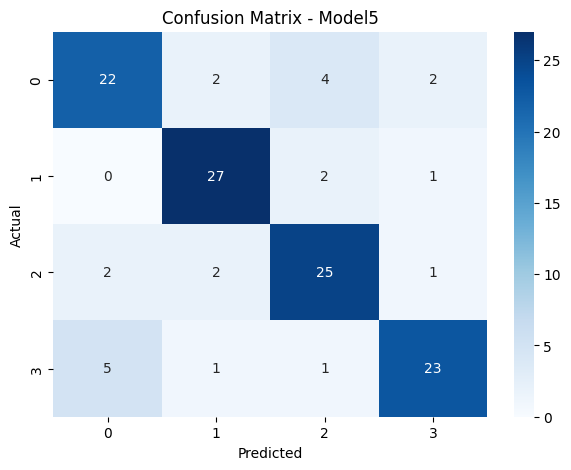

In [ ]:
cm_Model5 = confusion_matrix(y_test_Model5, y_pred_Model5)

plt.figure(figsize=(7,5))
sns.heatmap(cm_Model5, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Model5")
plt.show()

In [ ]:
results["Model5"] = {
    "Accuracy (%)": acc_Model5,
    "Prediction Time (ms)": pred_time_Model5,
    "Training Time (ms)": train_time_Model5,
    "Training Increment Memory (MiB)": training_increment_mem_Model5,
    "Prediction Increment Memory (MiB)": prediction_increment_mem_Model5,
    "Peak Memory (MiB)": peak_memory_mib_Model5,
    "Model Size (KB)": model_size_kb_Model5
}

# **RESULTS COMPARISON**

In [ ]:
df_results = pd.DataFrame.from_dict(results, orient='index')
df_results = df_results.round(2)   # rounds to 2 decimal places
df_results

,Accuracy (%),Prediction Time (ms),Training Time (ms),Training Increment Memory (MiB),Prediction Increment Memory (MiB),Peak Memory (MiB),Model Size (KB)
Tf_Model,98.51,10237.63,1766478.61,744.42,0.43,386668.00,130973.79
Model24,70.83,16.87,40.63,0.00,0.00,0.07,87.44
Model10,84.17,6.37,23.24,0.00,0.00,0.02,31.78
Model5,80.83,3.30,9.98,0.00,0.00,0.02,22.33


In [ ]:
df_results = pd.DataFrame(results).T
df_results.index.name = "Model"
models = df_results.index

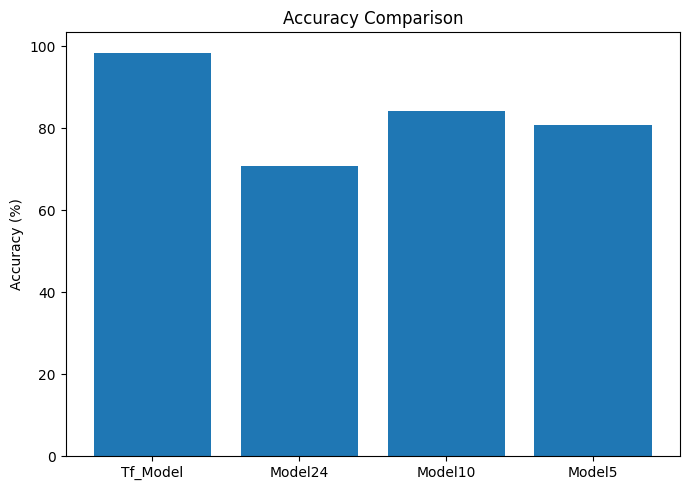

In [ ]:
plt.figure(figsize=(7,5))
plt.bar(models, df_results["Accuracy (%)"])
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.tight_layout()
plt.show()

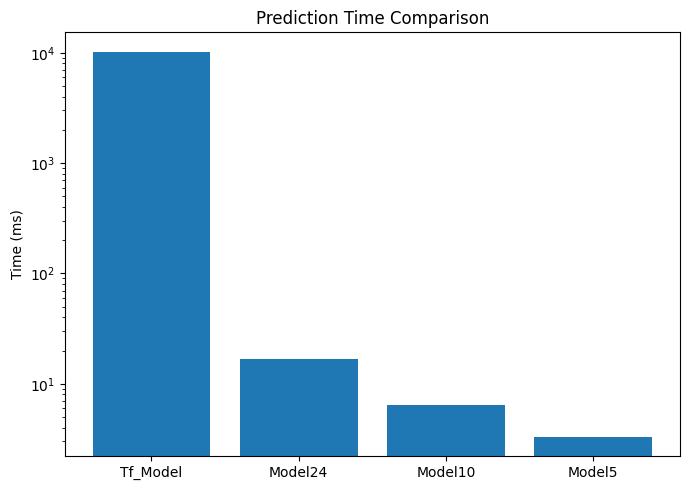

In [ ]:
plt.figure(figsize=(7,5))
plt.bar(models, df_results["Prediction Time (ms)"])
plt.yscale('log')
plt.title("Prediction Time Comparison")
plt.ylabel("Time (ms)")
plt.tight_layout()
plt.show()

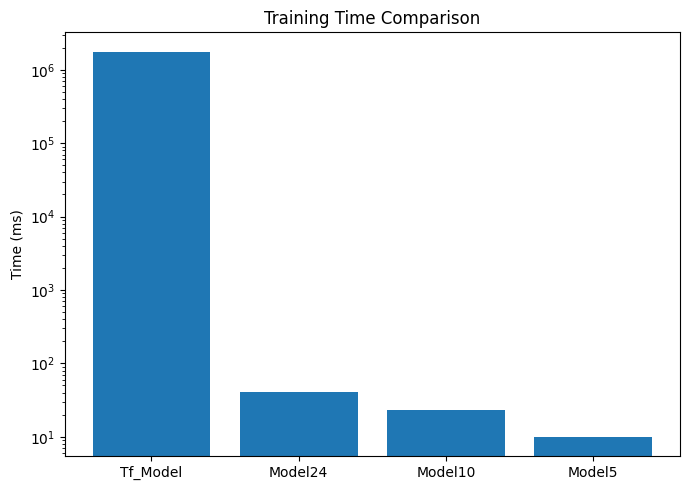

In [ ]:
plt.figure(figsize=(7,5))
plt.bar(models, df_results["Training Time (ms)"])
plt.yscale('log')
plt.title("Training Time Comparison")
plt.ylabel("Time (ms)")
plt.tight_layout()
plt.show()

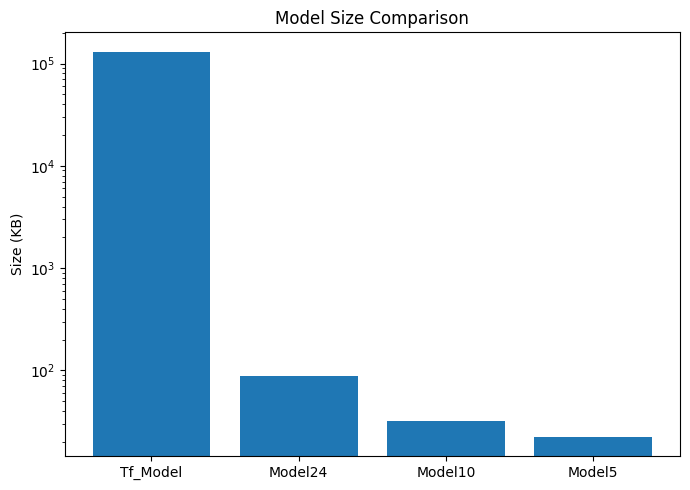

In [ ]:
plt.figure(figsize=(7,5))
plt.bar(models, df_results["Model Size (KB)"])
plt.yscale('log')
plt.title("Model Size Comparison")
plt.ylabel("Size (KB)")
plt.tight_layout()
plt.show()

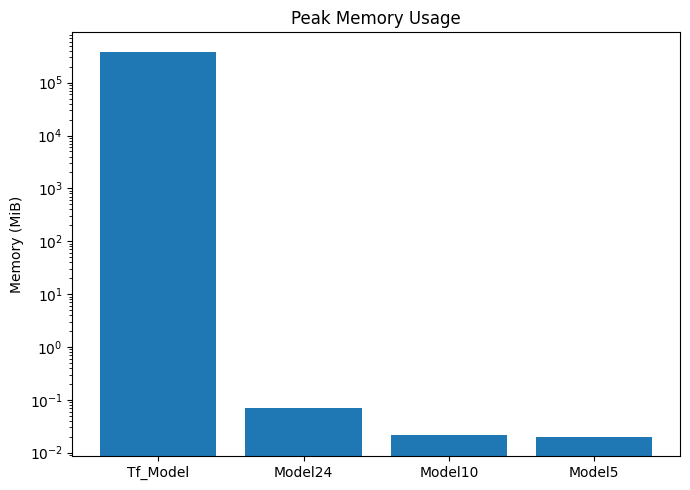

In [ ]:
plt.figure(figsize=(7,5))
plt.bar(models, df_results["Peak Memory (MiB)"])
plt.yscale('log')
plt.title("Peak Memory Usage")
plt.ylabel("Memory (MiB)")
plt.tight_layout()
plt.show()

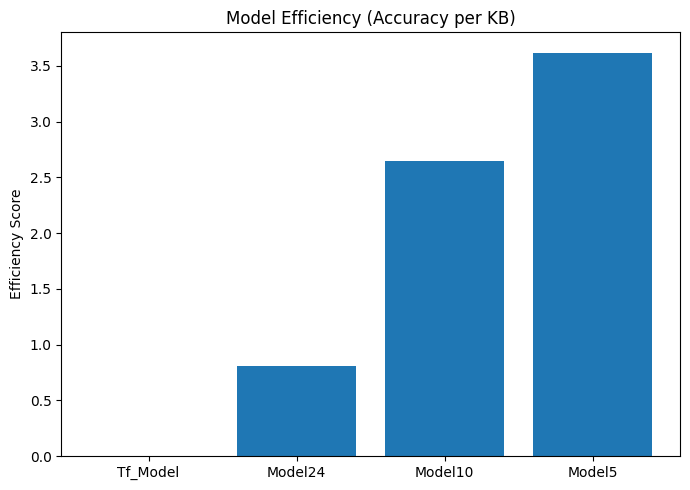

In [ ]:
df_results["Efficiency"] = df_results["Accuracy (%)"] / df_results["Model Size (KB)"]

plt.figure(figsize=(7,5))
plt.bar(models, df_results["Efficiency"])
plt.title("Model Efficiency (Accuracy per KB)")
plt.ylabel("Efficiency Score")
plt.tight_layout()
plt.show()